更新日0803

In [47]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#sysはコマンドライン引数
import sys
import csv
import pulp
np.seterr(divide='ignore', invalid='ignore')
#csvファイルの読み込み、一行目はヘッダーじゃない
df = pd.read_csv("../dataset/Trans_rand.csv",header=None)
df = df.drop(0, axis=1)
J_list = 0
#dfをnumpyで扱えるnp.ndarray変換
X = df.values
#配列の行数、列数の格納
X_size,dimension = X.shape

#クラスタ数宣言
c=5
#Kはクラスタサイズ(整数部分抽出)
K=X_size//c
#max繰り返し回数の宣言
max_iter=1

d=np.zeros((X_size,c))
sum_distance = []
#クラスター番号を格納するリスト
#目的関数を格納するリスト
best_centroids = np.zeros((c,dimension))
u_value = np.zeros((X_size,c))

NumberOfRepetitions=10

In [49]:
def v_calculation(u_value):
    #クラスタ中心の計算
    v=np.zeros((c,dimension))
    for i in range(c):    
        #分母
        numerator=0
        #分子
        denominator=0
        for j in range(X_size):
            numerator+=u_value[j][i]
            denominator+=u_value[j][i]*X[j]
        v[i]=denominator/numerator
    return v

In [50]:
for s in range (NumberOfRepetitions):
    print(f"{s+1}回目")
    centroids = X[np.random.choice(X_size,c)]
    for epoch in range(max_iter):
        for i in range(X_size):
            #各クラスタ中心との距離の格納
            d[i] = np.sum((centroids - X[i]) ** 2, axis=1)
            #print(distances)

        #d =distances.tolist()

        prob = pulp.LpProblem(name="u_best", sense=pulp.LpMinimize)
        #変数定義
        u=[]

        for i in range(X_size):
            sublist = []
            for j in range(c):
                sublist.append(pulp.LpVariable(name='u{}_{}'.format(i,j), cat='Countinuous', lowBound=0))
            u.append(sublist)

        #目的関数
        obj=0
        for i in range(X_size):
            for j in range(c):
                obj += d[i][j]*u[i][j]
        prob.setObjective(obj)

        #制約条件
        for i in range(X_size):
            prob += pulp.lpSum([u[i][j] for j in range(c)]) == 1 # sum
        for j in range(c):
            prob += pulp.lpSum([u[i][j] for i in range(X_size)]) >= K  # sum
            prob += pulp.lpSum([u[i][j] for i in range(X_size)]) <= K + 1 # sum

        #解く
        prob.solve()
        for i in range(X_size):
            for j in range(c):
                u_value[i][j] = u[i][j].value()
        #クラスター中心の更新
        new_centroids = v_calculation(u_value)

        #クラスター番号の格納
        cluster = [0 for i in range(X_size)]
        for i in range(X_size):
            for j in range(c):
                if u_value[i][j]==1:
                    cluster[i] =j
                else:
                    continue
        np_cluster = np.array(cluster)
        
        #----------ここまでUとVの交互最適化-----
        #終了条件
        
        #         if (np.array_equal(new_centroids, centroids)):
        #             print("breakします")
        #             break

        #         #繰り返し準備
        #         centroids = np.copy(new_centroids)
        
        if np.sum(np.abs(new_centroids-centroids))<=0.000001:
            print("中心が変わらないのでbreakします！")
            break
        centroids = np.copy(new_centroids)

        
    #目的関数の作成
    J = 0
    for i in range(c):
        J+= np.sum((X[np_cluster==i]-centroids[i])**2)
    #この初期値のときの結果が優れている場合，bestを更新
    if s == 0:
        best_cluster = np.copy(np_cluster)
        #最適な目的関数の更新
        best_J = J
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
    elif best_J > J:
        best_J = J
        best_centroids =  np.copy(new_centroids)
        best_cluster = np.copy(np_cluster)
    print(f"{s+1}回目のクラスタリング結果↓")
    print(best_J)
    print(best_centroids)
    print("終了")
print(best_cluster)
print(best_J)
print(best_centroids)

1回目
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/kouki/opt/anaconda3/envs/clustering/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/m3/07wc23_96wz9gkkdjrz3n_dw0000gn/T/5326da1a69a84eeca78d0279926370c4-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/m3/07wc23_96wz9gkkdjrz3n_dw0000gn/T/5326da1a69a84eeca78d0279926370c4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 50 COLUMNS
At line 709 RHS
At line 755 BOUNDS
At line 756 ENDATA
Problem MODEL has 45 rows, 175 columns and 525 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 45 (0) rows, 175 (0) columns and 525 (0) elements
Perturbing problem by 0.001% of 0.13465902 - largest nonzero change 1.0467889e-05 ( 9.5526383%) - largest zero change 9.832816e-06
0  Obj 0 Primal inf 69.999996 (40)
31  Obj 0.0026108492 Primal inf 24.999999 (13)
43  Obj 0.2

In [51]:
print(np.sum(u_value, axis=0))#列ごとの総和
print(np.sum(u_value, axis=1))#行ごとの総和

[7. 7. 7. 7. 7.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [52]:
#クラスター番号ごとに実際に振り分けられた個数を数える
unique, counts = np.unique(np_cluster, return_counts=True)
print(unique)
print(counts)

[0 1 2 3 4]
[7 7 7 7 7]


<Figure size 432x288 with 0 Axes>

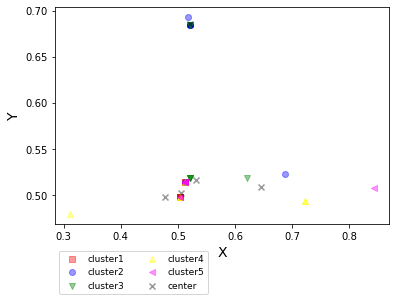

In [53]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster==i], X[:, 1][np_cluster==i], color=colors[i],marker=markers[i],alpha=0.4)
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x",alpha=0.4)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left') 
plt.show()


#fig.savefig("ransuu_ecbo.pdf",bbox_inches='tight')

In [56]:
fig.savefig("Trans_ecbo.pdf",bbox_inches='tight')

3を1\
4を3\
1を4

In [186]:
cluster_hensyuu = np_cluster
cluster_hensyuu_0 = np.where(cluster_hensyuu==1, 100, np_cluster)
cluster_hensyuu_1 = np.where(cluster_hensyuu_0==3, 1, cluster_hensyuu_0)
cluster_hensyuu_2 = np.where(cluster_hensyuu_1==4, 3, cluster_hensyuu_1)
cluster_hensyuu_3 = np.where(cluster_hensyuu_2==100, 4, cluster_hensyuu_2)

<Figure size 432x288 with 0 Axes>

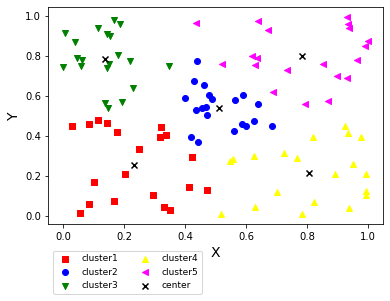

In [187]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][cluster_hensyuu_3==i], X[:, 1][cluster_hensyuu_3==i], color=colors[i],marker=markers[i])
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left') 
plt.show()


fig.savefig("ransuu_ecbo.pdf",bbox_inches='tight')

In [188]:
print(np.count_nonzero(cluster_hensyuu_3==0))
print(np.count_nonzero(cluster_hensyuu_3==1))
print(np.count_nonzero(cluster_hensyuu_3==2))
print(np.count_nonzero(cluster_hensyuu_3==3))
print(np.count_nonzero(cluster_hensyuu_3==4))

20
20
20
20
20
